In [1]:
import os
import re
import PIL
import sys
#import sls
import cv2
import json
import time
import glob
import math
import timm
import copy
import torch
import pickle
import geffnet
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from glob import glob
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
%config InlineBackend.figure_format = 'retina'
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score

In [2]:
from torch.utils.cpp_extension import CUDA_HOME
print(CUDA_HOME)

/usr


In [3]:
data_dir = '/home/linh/Downloads/Covid-19/CT/Yang'

#data_dir = '/home/linh/Downloads/Covid-19/CT/Soares'

# Define your transforms for the training and testing sets
data_transforms = {  
    'test':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256), #256 , 480
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224), #224, 448
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ]),
    'val':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ])

                    }

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test', 'val']}

batch_size = 256
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=4)
              for x in ['test', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test', 'val']}

class_names = image_datasets['test'].classes
n_classes = len(class_names)
print(n_classes)
print(class_names)
print(dataset_sizes)
print(device)


### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['test'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['test']))
images.size()

2
['COVID-19', 'NonCOVID-19']
{'test': 75, 'val': 75}
cuda:0
{0: 'COVID-19', 1: 'NonCOVID-19'}


torch.Size([75, 3, 224, 224])

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# MixNet ImageNet pretrained weight with image size = 224 for COMPUTED TOMOGRAPHY

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
14015482
checkpoint loaded
Training complete in 0m 1s
              precision    recall  f1-score   support

           0     0.8684    0.9429    0.9041        35
           1     0.9459    0.8750    0.9091        40

    accuracy                         0.9067        75
   macro avg     0.9072    0.9089    0.9066        75
weighted avg     0.9098    0.9067    0.9068        75



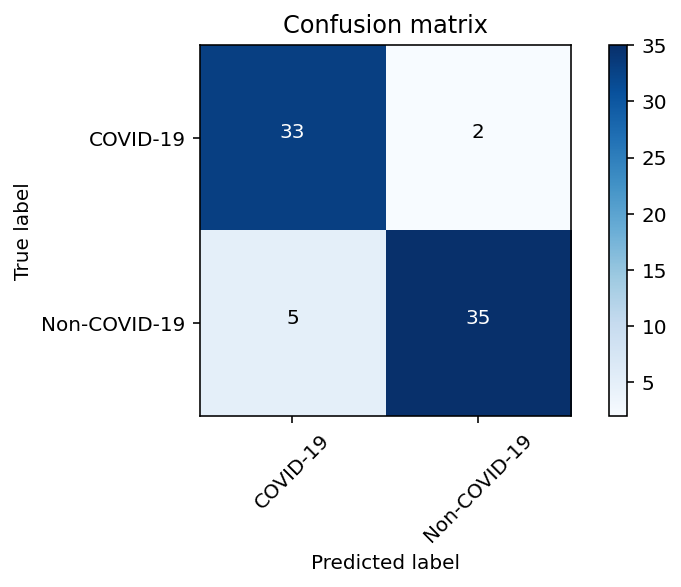

In [5]:
%time
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('mixnet_xl', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 ('fc1', nn.Linear(1536, 1000, bias=True)),
                                 #('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 2)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CT/MixNet_Extra_Large_Dataset_Yang.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CT/MixNet_Extra_Large_Dataset_Soares.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        
time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19', 'Non-COVID-19']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
AUC: 0.91


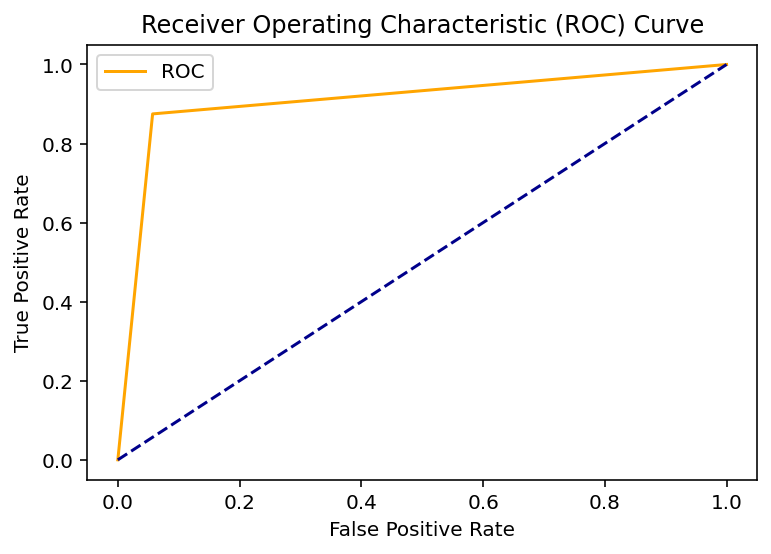

In [6]:
%time
auc = roc_auc_score(y_label, y_predict)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_label, y_predict)
plot_roc_curve(fpr, tpr)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs
14015482
checkpoint loaded
Training complete in 0m 1s
              precision    recall  f1-score   support

           0     0.9444    0.9714    0.9577        35
           1     0.9744    0.9500    0.9620        40

    accuracy                         0.9600        75
   macro avg     0.9594    0.9607    0.9599        75
weighted avg     0.9604    0.9600    0.9600        75

AUC: 0.96


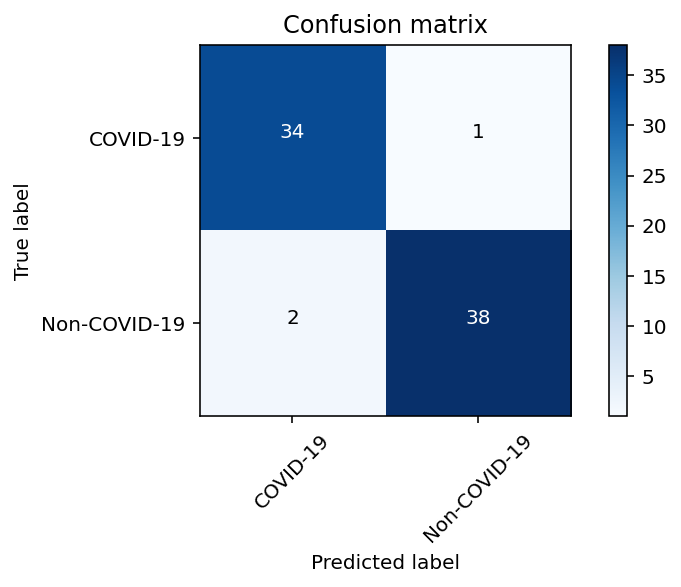

In [7]:
%time
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('mixnet_xl', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 ('fc1', nn.Linear(1536, 1000, bias=True)),
                                 #('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 2)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CT/MixNet_Extra_Large_Dataset_Yang.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CT/MixNet_Extra_Large_Dataset_Soares.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['val']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19', 'Non-COVID-19']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)
auc = roc_auc_score(y_label, y_predict)
print('AUC: %.2f' % auc)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
AUC: 0.96


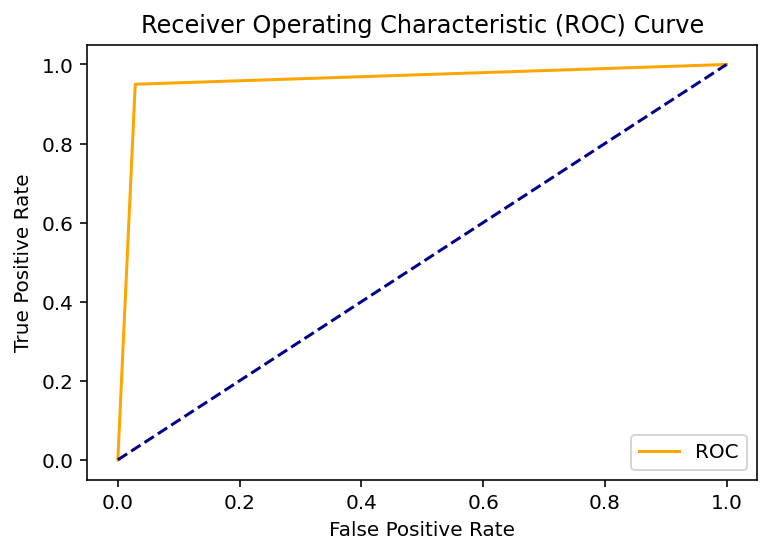

In [8]:
%time
auc = roc_auc_score(y_label, y_predict)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_label, y_predict)
plot_roc_curve(fpr, tpr)

# MixNet_XL using ImageNet pretrained weight with image size = 224 fro CHEST X RAY

In [9]:
%time
data_dir = '/home/linh/Downloads/Covid-19/CXR_20200630'
data_transforms = {  
    'test':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256), #256 , 480
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224), #224, 448
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ]),
    'val':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ])

                    }

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test', 'val']}

batch_size = 256
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=4)
              for x in ['test', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test', 'val']}

class_names = image_datasets['test'].classes
n_classes = len(class_names)
print(n_classes)
print(class_names)
print(dataset_sizes)
print(device)


### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['test'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['test']))
images.size()
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('mixnet_xl', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 ('fc1', nn.Linear(1536, 1000, bias=True)),
                                 #('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CXR/MixNet_Extra_Large_Dataset_20200630.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19', 'NORMAL', 'PNEUMONIA']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
3
['Covid-19', 'Normal', 'Pneumonia']
{'test': 2770, 'val': 2758}
cuda:0
{0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia'}
14015611
checkpoint not found


TypeError: 'NoneType' object is not subscriptable

In [ ]:
%time
auc = roc_auc_score(y_label, y_predict)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_label, y_predict)
plot_roc_curve(fpr, tpr)

In [ ]:
%time
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('mixnet_xl', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 ('fc1', nn.Linear(1536, 1000, bias=True)),
                                 #('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CXR/MixNet_Extra_Large_Dataset_20200630.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['val']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19', 'NORMAL', 'PNEUMONIA']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

# Ensemble voting of 6 models with image size = 224

In [ ]:
def get_Eff_B0():
    model = timm.create_model('efficientnet_b0', pretrained=True)

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    return model
    
def get_MixNet_S():
    model = timm.create_model('mixnet_s', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Small_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model

def get_MixNet_M():
    model = timm.create_model('mixnet_m', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Medium_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model


def get_MixNet_L():
    model = timm.create_model('mixnet_l', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model


def get_MixNet_XL():
    model = timm.create_model('mixnet_xl', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Extra_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model


def get_MixNet_XXL():
    model = timm.create_model('mixnet_xxl', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Extra_Extra_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model

In [ ]:
class Ensemble_Model(nn.Module):
    def __init__(self):
        super(Ensemble_Model, self).__init__()
        self.Eff_B0 = get_Eff_B0()
        self.MixNet_S = get_MixNet_S()
        self.MixNet_M = get_MixNet_M()
        self.MixNet_L = get_MixNet_L()
        self.MixNet_XL = get_MixNet_XL()
        self.MixNet_XXL = get_MixNet_XXL()
    def forward(self, x):
        x1 = self.Eff_B0(x)
        x2 = self.MixNet_S(x)
        x3 = self.MixNet_M(x)
        x4 = self.MixNet_L(x)
        x5 = self.MixNet_XL(x)
        x6 = self.MixNet_XXL(x)

        x = sum([x1, x2, x3, x4, x5, x6]) / 6
        return x
    
model = Ensemble_Model()

In [ ]:
since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['test']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())


time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Ensemble_Eff_B0_MixNet_S_MixNet_M_MixNet_L_XL_XXL_Testset.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)